In [3]:
import tensorflow as tf
from tensorflow import keras

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


In [4]:
dataset_path = 'D:/10th Semester/CVPR/FaceRecognition/Imagedata/train'

In [6]:


def load_dataset(dataset_path):
    images = []
    labels = []
    label_names = os.listdir(dataset_path)
    total_width = 0
    total_height = 0
    num_images = 0
    for index, name in enumerate(tqdm(label_names)):
        folder_path = os.path.join(dataset_path, name)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            if image is not None:  
                num_images += 1
                total_width += image.shape[1]
                total_height += image.shape[0]
                images.append(image)
                labels.append(index)
            else:
                print(f"Warning: Could not load image {image_path}")
    average_width = round(total_width / num_images)
    average_height =round(total_height / num_images)
    
    resized_images = []
    for image in images:
        resized_image = cv2.resize(image, (int(average_width), int(average_height)))  
        resized_images.append(resized_image)
    
    resized_images = np.array(resized_images, dtype='float32') / 255.0  
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=len(label_names))
    return resized_images, labels, label_names, average_width, average_height


images, labels, label_names, avg_width, avg_height = load_dataset(dataset_path)
print("Average Width:", avg_width)
print("Average Height:", avg_height)
print("Label Names:", label_names)


100%|██████████| 3/3 [00:00<00:00, 24.69it/s]

Average Width: 509
Average Height: 509
Label Names: ['MOHAMMAD_RAFIUL_HAQUE', 'Ridwan_Ahmed_Arman', 'TARIKUL_ISLAM_NISHAT']


In [7]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [8]:

def build_model(num_classes, avg_height, avg_width):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(avg_height, avg_width, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(512, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax'),
    ])
    return model

model = build_model(num_classes=len(label_names), avg_height=avg_height, avg_width=avg_width)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Train model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=16)


Epoch 1/30
2/2 [==============================] - 5s 2s/step - loss: 1.1303 - accuracy: 0.3929 - val_loss: 1.2761 - val_accuracy: 0.1429
Epoch 2/30
2/2 [==============================] - 4s 2s/step - loss: 1.0721 - accuracy: 0.4643 - val_loss: 1.1631 - val_accuracy: 0.1429
Epoch 3/30
2/2 [==============================] - 4s 2s/step - loss: 0.9990 - accuracy: 0.4643 - val_loss: 1.1900 - val_accuracy: 0.1429
Epoch 4/30
2/2 [==============================] - 3s 2s/step - loss: 0.9546 - accuracy: 0.4643 - val_loss: 1.2166 - val_accuracy: 0.1429
Epoch 5/30
2/2 [==============================] - 4s 2s/step - loss: 0.8970 - accuracy: 0.5000 - val_loss: 1.1925 - val_accuracy: 0.1429
Epoch 6/30
2/2 [==============================] - 4s 2s/step - loss: 0.8302 - accuracy: 0.7500 - val_loss: 1.1453 - val_accuracy: 0.1429
Epoch 7/30
2/2 [==============================] - 4s 2s/step - loss: 0.7291 - accuracy: 0.7857 - val_loss: 1.1240 - val_accuracy: 0.4286
Epoch 8/30
2/2 [=========================

In [11]:
import h5py
model.save("face_recognition.h5")

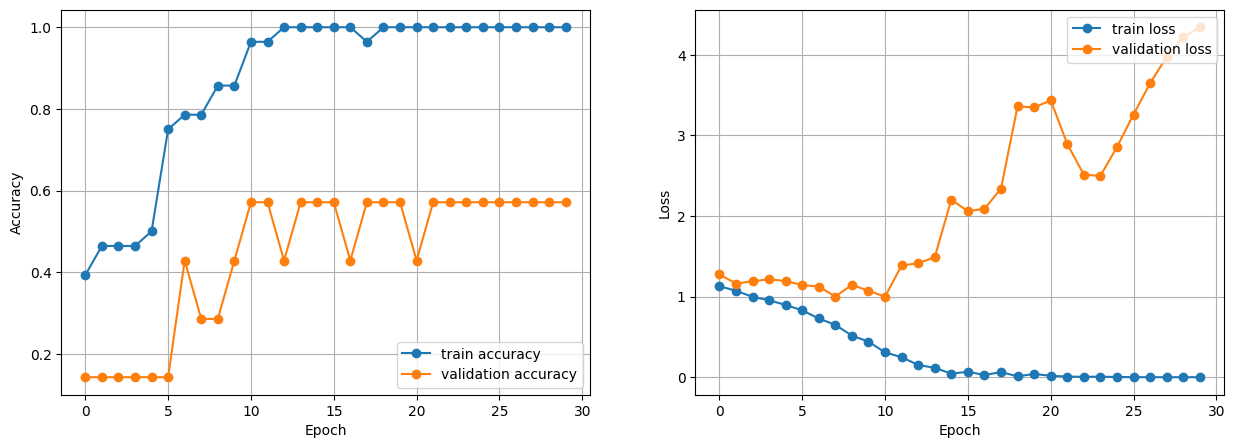

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='train accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='train loss')
plt.plot(history.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [8]:
import cv2
import h5py
import numpy as np
from keras.models import load_model

def real_time_recognition(model, label_names):
    cap = cv2.VideoCapture(0)
 
    if not cap.isOpened():
        raise IOError("Cannot open webcam")
    
    while True:
        ret, frame = cap.read() 
        if not ret:
            break
        
        face = cv2.resize(frame, (509, 509)) 
        face = np.expand_dims(face, axis=0)  
        face = face / 255.0  
        
        prediction = model.predict(face) 
        predicted_class = label_names[np.argmax(prediction)]  
        
        cv2.putText(frame, predicted_class, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
        cv2.imshow('Real-time Face Recognition', frame)
        
        # Check if the 'q' key is pressed to quit
        key = cv2.waitKey(1)
        if key == ord('q') or key == 27:  # 'q' or 'Esc' key
            break
    
    cap.release()
    cv2.destroyAllWindows()

# Load the pre-trained model and label names
loaded_model = load_model("face_recognition.h5")
labelnames = ['MOHAMMAD_RAFIUL_HAQUE', 'Ridwan_Ahmed_Arman', 'TARIKUL_ISLAM_NISHAT']

# Run real-time face recognition
real_time_recognition(loaded_model, labelnames)


1/1 [==============================] - 0s 55ms/step


In [ ]:
##Thsi was for dynamic size (avg size) based on dataset when training
# import cv2
# import h5py
# import numpy as np
# from keras.models import load_model

# def real_time_recognition(model, label_names):

#     cap = cv2.VideoCapture(0)
    
 
#     if not cap.isOpened():
#         raise IOError("Cannot open webcam")
    
#     while True:
#         ret, frame = cap.read() 
#         if not ret:
#             break
        
#         face = cv2.resize(frame, (avg_height, avg_width)) 
#       # face = cv2.resize(frame, (600, 600)) 
#         face = np.expand_dims(face, axis=0)  
#         face = face / 255.0  
        
#         prediction = model.predict(face) 
#         predicted_class = label_names[np.argmax(prediction)]  
        
     
#         cv2.putText(frame, predicted_class, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
  
#         cv2.imshow('Real-time Face Recognition', frame)
        
   
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    
   
#     cap.release()
#     cv2.destroyAllWindows()


# loaded_model = load_model("face_recognition.h5")
# labelNames=['MOHAMMAD_RAFIUL_HAQUE', 'Ridwan_Ahmed_Arman', 'TARIKUL_ISLAM_NISHAT']

# real_time_recognition(loaded_model, labelNames)
